In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd

pd.set_option('display.max_rows', 10)
!date

Thu May 14 14:47:48 PDT 2020


# Quantify population structure change in King County from 2010 (decennial) to 2018 (acs)

decennial data from: https://ciser.cornell.edu/data/data-archive/census-2010-sf1-download-center/`

decennial data codebook: https://cisermgmt.cornell.edu/go/pub/2010SF1/Census_2010_SF1_Technical_Documentation.pdf

ACS data from : https://data.census.gov/cedsci/advanced

shapefiles from: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html, 'web interface'

## read in decennial data

In [3]:
locs = ['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK']

keep_cols = ['P0010001', 'ZCTA'] + locs

def my_cols(x):
    if x.startswith('P01200'):
        return True
    else:
        return (x in keep_cols)

In [4]:
%%time

decennial = pd.read_csv('/home/j/temp/beatrixh/2020_census/wa2010ur1_all_vars.CSV', usecols = my_cols)

CPU times: user 39.2 s, sys: 1.45 s, total: 40.6 s
Wall time: 43.2 s


In [5]:
decennial = decennial[decennial.BLOCK.notna()]

In [6]:
#add geoid

# get a list of all cols needed for geoid
lower_locs = [i.lower() for i in locs]

# convert to strings
decennial[lower_locs] = decennial[locs].astype(float).astype(int).astype(str)
decennial[lower_locs] = decennial[lower_locs].astype(str)

# rearrange loc vars to be strings of uniform length
decennial.county = [('00' + i) if len(i)==1
             else '0' + i if len(i)==2
             else i for i in decennial.county]

decennial.tract = ['0' + i if len(i)==5
            else '00' + i if len(i)==4
            else '000' + i if len(i)==3
            else i for i in decennial.tract]

decennial.block = ['0' + i if len(i)==3
            else '00' + i if len(i)==2
            else '000' + i if len(i)==1
            else i for i in decennial.block]

# add geoid
decennial['geoid'] = decennial['state'] + decennial['county'] + decennial['tract'] + decennial['block']
print(decennial['geoid'].head())

#these should all be length 15:
print(set([len(i) for i in decennial.geoid]))

59    530019502003244
60    530019502003250
61    530019502003251
62    530019502003252
63    530019502003254
Name: geoid, dtype: object
{15}


## read in acs

In [13]:
acs = pd.read_csv('/home/j/temp/beatrixh/sim_science/ACS_2018/ACSST5Y2018.S0101-age_sex/ACSST5Y2018.S0101_data_with_overlays_2020-05-14T175825.csv')
metadata = pd.read_csv('/home/j/temp/beatrixh/sim_science/ACS_2018/ACSST5Y2018.S0101-age_sex/ACSST5Y2018.S0101_metadata_2020-05-14T175825.csv')

In [14]:
acs.head()

,GEO_ID,NAME,S0101_C01_001E,S0101_C01_001M,S0101_C02_001E,S0101_C02_001M,S0101_C03_001E,S0101_C03_001M,S0101_C04_001E,S0101_C04_001M,...,S0101_C02_038E,S0101_C02_038M,S0101_C03_038E,S0101_C03_038M,S0101_C04_038E,S0101_C04_038M,S0101_C05_038E,S0101_C05_038M,S0101_C06_038E,S0101_C06_038M
0,id,Geographic Area Name,Estimate!!Total!!Total population,Margin of Error!!Total MOE!!Total population,Estimate!!Percent!!Total population,Margin of Error!!Percent MOE!!Total population,Estimate!!Male!!Total population,Margin of Error!!Male MOE!!Total population,Estimate!!Percent Male!!Total population,Margin of Error!!Percent Male MOE!!Total popul...,...,Estimate!!Percent!!PERCENT ALLOCATED!!Age,Margin of Error!!Percent MOE!!PERCENT ALLOCATE...,Estimate!!Male!!PERCENT ALLOCATED!!Age,Margin of Error!!Male MOE!!PERCENT ALLOCATED!!Age,Estimate!!Percent Male!!PERCENT ALLOCATED!!Age,Margin of Error!!Percent Male MOE!!PERCENT ALL...,Estimate!!Female!!PERCENT ALLOCATED!!Age,Margin of Error!!Female MOE!!PERCENT ALLOCATED...,Estimate!!Percent Female!!PERCENT ALLOCATED!!Age,Margin of Error!!Percent Female MOE!!PERCENT A...
1,1400000US53001950100,"Census Tract 9501, Adams County, Washington",2493,201,(X),(X),1289,108,(X),(X),...,3.0,(X),(X),(X),(X),(X),(X),(X),(X),(X)
2,1400000US53001950200,"Census Tract 9502, Adams County, Washington",1705,159,(X),(X),815,83,(X),(X),...,0.2,(X),(X),(X),(X),(X),(X),(X),(X),(X)
3,1400000US53001950300,"Census Tract 9503, Adams County, Washington",6884,276,(X),(X),3430,217,(X),(X),...,2.3,(X),(X),(X),(X),(X),(X),(X),(X),(X)
4,1400000US53001950400,"Census Tract 9504, Adams County, Washington",3399,342,(X),(X),1766,237,(X),(X),...,4.1,(X),(X),(X),(X),(X),(X),(X),(X),(X)


In [15]:
metadata.head()

,GEO_ID,id,Unnamed: 2
0,NAME,Geographic Area Name,NaN
1,S0101_C01_001E,Estimate!!Total!!Total population,NaN
2,S0101_C01_001M,Margin of Error!!Total MOE!!Total population,NaN
3,S0101_C01_002E,Estimate!!Total!!Total population!!AGE!!Under ...,NaN
4,S0101_C01_002M,Margin of Error!!Total MOE!!Total population!!...,NaN


In [124]:
age_vars = metadata[(metadata.id=='Estimate!!Total!!Total population') | (metadata.id.str.contains('Estimate!!Total!!Total population!!AGE!!'))].GEO_ID.tolist()

In [132]:
# subset to vars of interest
acs_age = acs[['GEO_ID','NAME'] + age_vars]

In [133]:
acs_age['GEO_ID'] = acs_age.GEO_ID.str[9:]

/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [134]:
# rename vars
new_labs = ['total_pop'] + ['age_' + str(i) + '_' + str(i+4) for i in np.arange(0,81,5)] + ['age_85_plus']

renaming = {}
for i in np.arange(len(acs_age.columns[2:])):
    renaming[acs_age.columns[2:][i]] = new_labs[i]
    
renaming['GEO_ID'] = 'tract_geoid'

In [135]:
acs_age = acs_age.iloc[1:].rename(columns=renaming)

In [234]:
#subset to king county

acs_age = acs_age[acs_age.tract_geoid.str[:5]=='53033']

## read in decennial data

In [212]:
decennial = pd.read_csv('/home/j/Project/simulation_science/covid/data/census_data/2020_05_14_king_county_population_distribution_2010.csv')

In [213]:
decennial.head()

,total_pop,m_total,m_0_4,m_5_9,m_10_14,m_15_17,m_18_19,m_20,m_21,m_22_24,...,f_80_84,f_85_plus,state,county,tract,blkgrp,block,geoid,area,pop_density
0,0,0,0,0,0,0,0,0,0,0,...,0,0,53,33,31202,1,1014,530330312021014,0.033603,0.000000
1,309,158,7,11,14,16,3,2,2,6,...,1,2,53,33,31202,1,1017,530330312021017,2.149353,143.764175
2,6,2,0,0,0,0,0,0,0,0,...,0,0,53,33,31202,1,1018,530330312021018,0.005844,1026.702491
3,0,0,0,0,0,0,0,0,0,0,...,0,0,53,33,31202,2,2000,530330312022000,0.123027,0.000000
4,97,50,0,0,1,25,13,1,0,0,...,0,1,53,33,31202,2,2001,530330312022001,0.268237,361.620856


In [214]:
decennial['m_15_19'] = decennial[['m_15_17','m_18_19']].sum(axis=1)
decennial['f_15_19'] = decennial[['f_15_17','f_18_19']].sum(axis=1)

decennial['m_20_24'] = decennial[['m_20','m_21','m_22_24']].sum(axis=1)
decennial['f_20_24'] = decennial[['f_20','f_21','f_22_24']].sum(axis=1)

decennial['m_60_64'] = decennial[['m_60_61', 'm_62_64']].sum(axis=1)
decennial['f_60_64'] = decennial[['f_60_61', 'f_62_64']].sum(axis=1)

decennial['m_65_69'] = decennial[['m_65_66', 'm_67_69']].sum(axis=1)
decennial['f_65_69'] = decennial[['f_65_66', 'f_67_69']].sum(axis=1)

In [215]:
decennial = decennial.drop(columns=['m_15_17','m_18_19','f_15_17','f_18_19',
                                    'm_20','m_21','m_22_24','f_20','f_21','f_22_24',
                                    'm_60_61', 'm_62_64','f_60_61', 'f_62_64',
                                    'm_65_66', 'm_67_69','f_65_66', 'f_67_69'])

In [216]:
endings =  [str(i) + '_' + str(i+4) for i in np.arange(0,81,5)] + ['85_plus']

for i in endings:
    var = 'age_' + i
    decennial[var] = decennial.loc[:,decennial.columns.str.endswith(i)].sum(axis=1)

In [217]:
decennial['tract_geoid'] = decennial.geoid.astype(str).str[:11]
decennial = decennial.groupby('tract_geoid').sum()

In [220]:
decennial.reset_index(inplace=True)

In [248]:
decennial = decennial[['tract_geoid','total_pop'] + ['age_' + str(i) + '_' + str(i+4) for i in np.arange(0,81,5)] + ['age_85_plus']]

In [249]:
decennial.head()

,tract_geoid,total_pop,age_0_4,age_5_9,age_10_14,age_15_19,age_20_24,age_25_29,age_30_34,age_35_39,age_40_44,age_45_49,age_50_54,age_55_59,age_60_64,age_65_69,age_70_74,age_75_79,age_80_84,age_85_plus
0,53033000100,6255,362,287,227,324,624,667,527,464,408,431,449,439,372,223,147,101,97,106
1,53033000200,7646,423,319,289,335,570,728,695,607,574,499,570,536,437,293,203,191,190,187
2,53033000300,2603,176,125,117,112,158,217,244,225,199,207,214,202,136,95,74,45,40,17
3,53033000401,5551,260,179,160,246,508,627,406,348,344,315,330,326,359,307,209,200,224,203
4,53033000402,4841,243,184,145,168,255,382,363,354,329,315,318,316,230,150,114,109,237,629


In [250]:
decennial_long = decennial.melt(id_vars='tract_geoid', value_vars = decennial.iloc[:,1:].columns.tolist(), value_name='decennial')
acs_long = acs_age.melt(id_vars='tract_geoid', value_vars = acs_age.iloc[:,2:].columns.tolist(), value_name='acs')

In [256]:
df_long = acs_long.merge(decennial_long, on = ['tract_geoid','variable'])

In [281]:
df_long.head()

,tract_geoid,variable,acs,decennial
0,53033000100,total_pop,7985,6255
1,53033000200,total_pop,8498,7646
2,53033000300,total_pop,2991,2603
3,53033000401,total_pop,6560,5551
4,53033000402,total_pop,5419,4841


In [285]:
df_long.acs = df_long.acs.astype(np.int64)

In [286]:
df_long['pct_change'] = df_long['acs'] / df_long['decennial']
df_long['abs_change'] = df_long['acs'] - df_long['decennial']

In [321]:
df_long.head()

,tract_geoid,variable,acs,decennial,pct_change,abs_change
0,53033000100,total_pop,7985,6255,1.276579,1730
1,53033000200,total_pop,8498,7646,1.111431,852
2,53033000300,total_pop,2991,2603,1.149059,388
3,53033000401,total_pop,6560,5551,1.181769,1009
4,53033000402,total_pop,5419,4841,1.119397,578


In [322]:
df_long.to_csv('/home/j/Project/simulation_science/covid/data/census_data/2020_05_14_king_county_population_change_2010-2018.csv', index = False)

## viz results

In [287]:
shapes = gpd.read_file('/home/j/temp/beatrixh/sim_science/census_GIS/tl_2018_53_tract/tl_2018_53_tract.shp')

In [288]:
# subset to king county
shapes = shapes[shapes.COUNTYFP=='033']

In [289]:
shapes['key'] = shapes.GEOID.astype(int)
shapes = shapes.sort_values(by='key')

df_total_pop = df_long[df_long.variable=='total_pop']
df_total_pop['key'] = df_total_pop.tract_geoid.astype(int)
df_total_pop = df_total_pop.sort_values(by='key')

/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [306]:
df_total_pop['pct_change'].astype(float)

0      1.276579
1      1.111431
2      1.149059
3      1.181769
4      1.119397
         ...   
393    1.026738
394    1.131188
395    1.172431
396    0.823220
397         NaN
Name: pct_change, Length: 398, dtype: float64

In [307]:
shapes['total_pop_pct_change'] = df_total_pop['pct_change'].astype(float).tolist()
shapes['total_pop_abs_change'] = df_total_pop.abs_change.astype(np.int64)

In [308]:
shapes.dtypes

STATEFP                   object
COUNTYFP                  object
TRACTCE                   object
GEOID                     object
NAME                      object
                          ...   
INTPTLON                  object
geometry                geometry
key                        int64
total_pop_pct_change     float64
total_pop_abs_change     float64
Length: 16, dtype: object

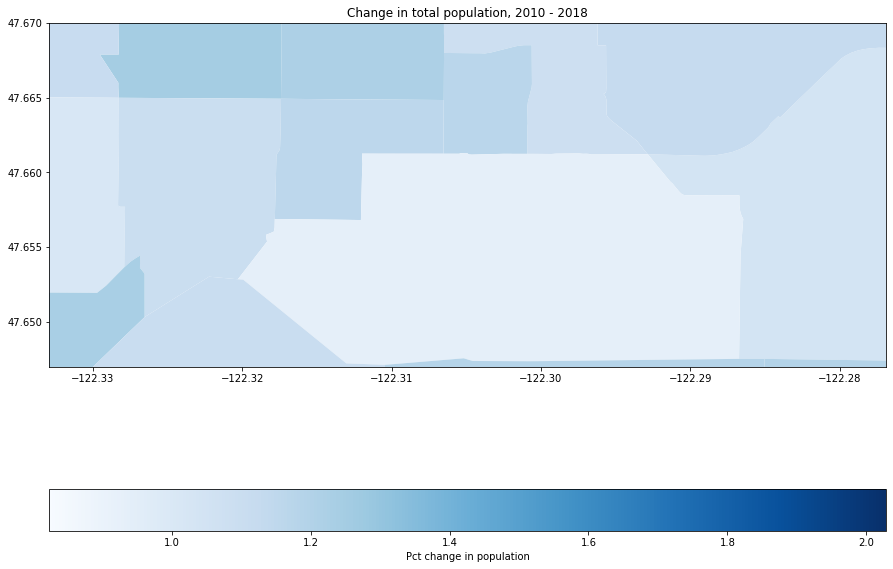

In [320]:
fig, ax = plt.subplots(figsize = (15,15))

ax.set_xlim(-122.332927, -122.276884)
ax.set_ylim(47.647, 47.67)

plt.title('Change in total population, 2010 - 2018')

shapes.plot(ax=ax, column='total_pop_pct_change', cmap = 'Blues',
            legend = True,
            legend_kwds={'label': "Pct change in population",'orientation': "horizontal"})
plt.show()

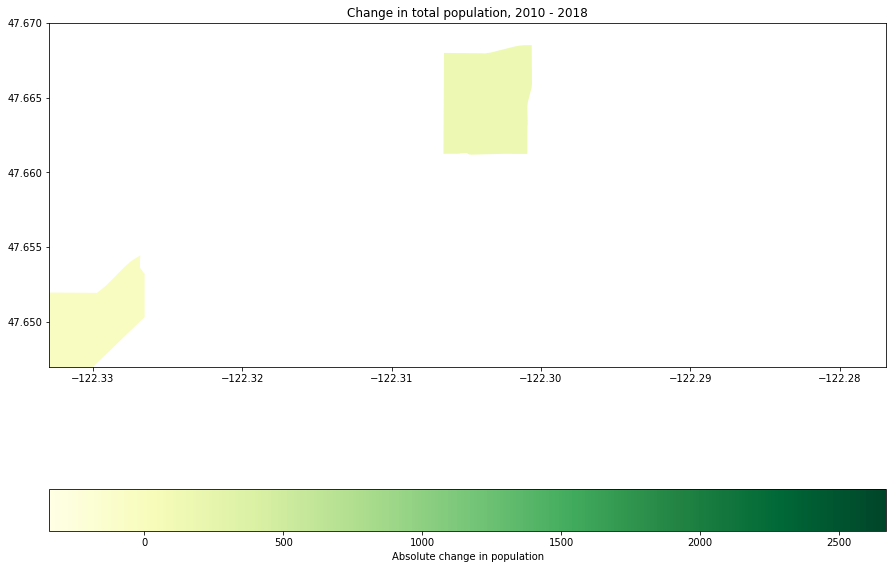

In [311]:
fig, ax = plt.subplots(figsize = (15,15))

ax.set_xlim(-122.332927, -122.276884)
ax.set_ylim(47.647, 47.67)

plt.title('Change in total population, 2010 - 2018')

shapes.plot(ax=ax, column='total_pop_abs_change', cmap = 'YlGn',
            legend = True,
            legend_kwds={'label': "Absolute change in population",'orientation': "horizontal"})
plt.show()

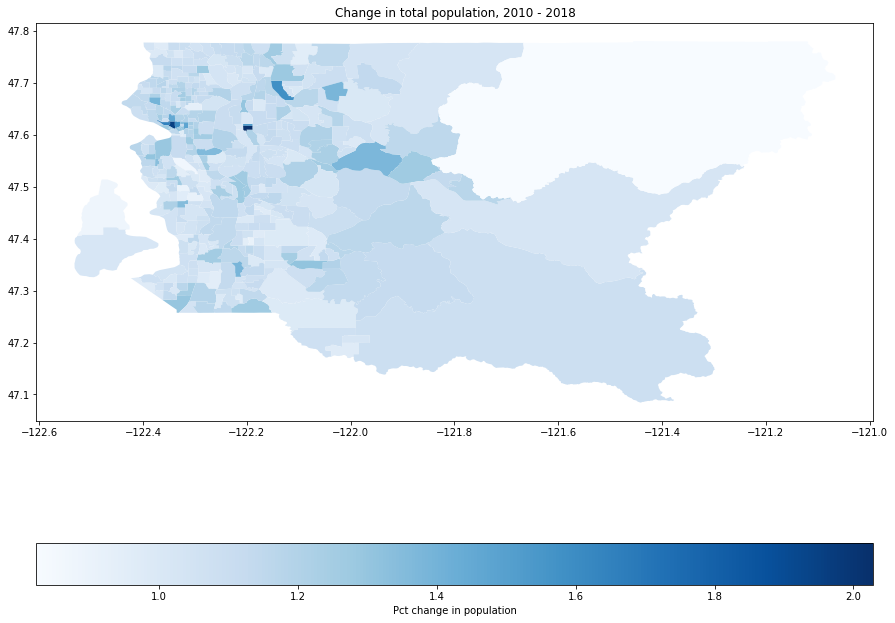

In [316]:
fig, ax = plt.subplots(figsize = (15,15))

plt.title('Change in total population, 2010 - 2018')

shapes.plot(ax=ax, column='total_pop_pct_change', cmap = 'Blues',
            legend = True,
            legend_kwds={'label': "Pct change in population",'orientation': "horizontal"})
plt.show()